# This notebook reads the FITS File generated by Dsim


In [102]:
%matplotlib notebook

import sys
import logging
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../DesignTool")
from smdtLibs.configFile import ConfigFile
from targets import TargetList
from smdtLibs.inOutChecker import InOutChecker
from maskDesignFile import (
    MaskDesignInputFitsFile,
    MaskDesignOutputFitsFile,
    outputAsList,
)
from maskLayouts import MaskLayouts, GuiderFOVs, shrinkMask
from smdtLibs import utils, drawUtils
from astropy.modeling import models, fitting

<IPython.core.display.Javascript object>

In [103]:
try:
    %load_ext nb_black
except:
    print("Ignore extension nb_black")
    pass

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [104]:
logging.disable()

<IPython.core.display.Javascript object>

## Read the config file and the parameter file

In [105]:
config_fname = "../DesignTool/smdt.cfg"
param_fname = "../DesignTool/params.cfg"

config = ConfigFile(config_fname)
config.properties["params"] = ConfigFile(param_fname)

<IPython.core.display.Javascript object>

## The mask layout

In [106]:
layout = MaskLayouts["deimosOrig"]
guiderLayout = GuiderFOVs["deimosOrig"]

<IPython.core.display.Javascript object>

## Read the Mask Design FITS file

DSIM generates a FITS file that contains:
- Table objectcat: star catalog
- Table catfiles:  input catalog file name(s), not used?
- Table maskdesign: mask's metadata, contains reference RA/DEC
- Table desislits: Slits RA/DEC, lengths, PAs
- Table slitobjmap: object position inside the slits
- Table maskblu: more meta data, includes, temp, humidity, pressure, wavelength
- Table bluslits: slist coordiantes, 4 corners
- Table rdbmap: field name mapping to database


In [107]:
input_fname = "../DeimosExamples/EvanKirby/n2419c.fits"
mdf = MaskDesignInputFitsFile(input_fname)

<IPython.core.display.Javascript object>

### Define the coordinates of the center

The center (RA/DEC) is defined in the input target list, first row.

This is different than the pointing coordinates in the FITS file, table maskdesign reference RA/DEC.


In [108]:
CenterLine = "n2419c             7:38:09.20   38:51:12.0  2000.0 PA=50.000 ##"
parts = CenterLine.split()
cenRA = utils.sexg2Float(parts[1]) * 15
cenDEC = utils.sexg2Float(parts[2])

<IPython.core.display.Javascript object>

### Compare Center RA/DEC to Pointing RA/DEC

Center RA/DEC is the one from the CenterLine see above.

Pointing RA/DEc is from the FITS file.

In [109]:
pntCenRa, pntCenDec = mdf.getCenter()  # As stored in the FITS file

print(
    "Pnt Coords \tRA {}, DEC {}\nCenter \t\tRA {}, DEC {}".format(
        utils.toSexagecimal(pntCenRa / 15),
        utils.toSexagecimal(pntCenDec),
        utils.toSexagecimal(cenRA / 15),
        utils.toSexagecimal(cenDEC),
    )
)

Pnt Coords 	RA  07:38:22.33, DEC  38:47:34.60
Center 		RA  07:38:09.20, DEC  38:51:12.00


<IPython.core.display.Javascript object>

### Check which targets are inside or selected

In [110]:
tlist = mdf.getAsTargets(cenRA, cenDEC, config)  # Gets targets as TargetList object
tlist.markInside(layout)

<IPython.core.display.Javascript object>

In [111]:
raHs, decs = np.array([pntCenRa / 15.0, cenRA / 15.0]), np.array([pntCenDec, cenDEC])

# Note: tlist.telRaRad/telDecRad = cenRA/cenDEC
censX, censY = tlist._calcTelTargetCoords(
    tlist.telRaRad, tlist.telDecRad, raHs, decs, tlist.positionAngle
)

#  censX/censY projected positions of the array raHs/decs in the focal plane
labels = "Pointing", "CenerLine"
print(f"{' ':<12s} {'X':>7s}, {'Y':>7s}")
for lb, cx, cy in zip(labels, censX, censY):
    print(f"{lb:<12s} {cx:7.2f}, {cy:7.2f}")

                   X,       Y
Pointing      -22.33,    4.87
CenerLine      -0.00,  270.00


<IPython.core.display.Javascript object>

In [112]:
# For testing only
# outputAsList("test.list", tlist.targets)

<IPython.core.display.Javascript object>

## Get shortcuts for inside targets, alignment boxes, guider boxes

In [113]:
allTargets = tlist.targets

selectedTargets = allTargets[
    np.logical_and(allTargets.pcode > 0, allTargets.selected > 0)
]
inTargets = allTargets[allTargets.inMask > 0]
alignBoxes = allTargets[allTargets.pcode == -2]
guideBoxes = allTargets[allTargets.pcode == -1]

inSelectedTargets = selectedTargets[selectedTargets.inMask > 0]
inAlignBoxes = alignBoxes[alignBoxes.inMask > 0]

<IPython.core.display.Javascript object>

### Plot the mask layout and the targets inside

<IPython.core.display.Javascript object>


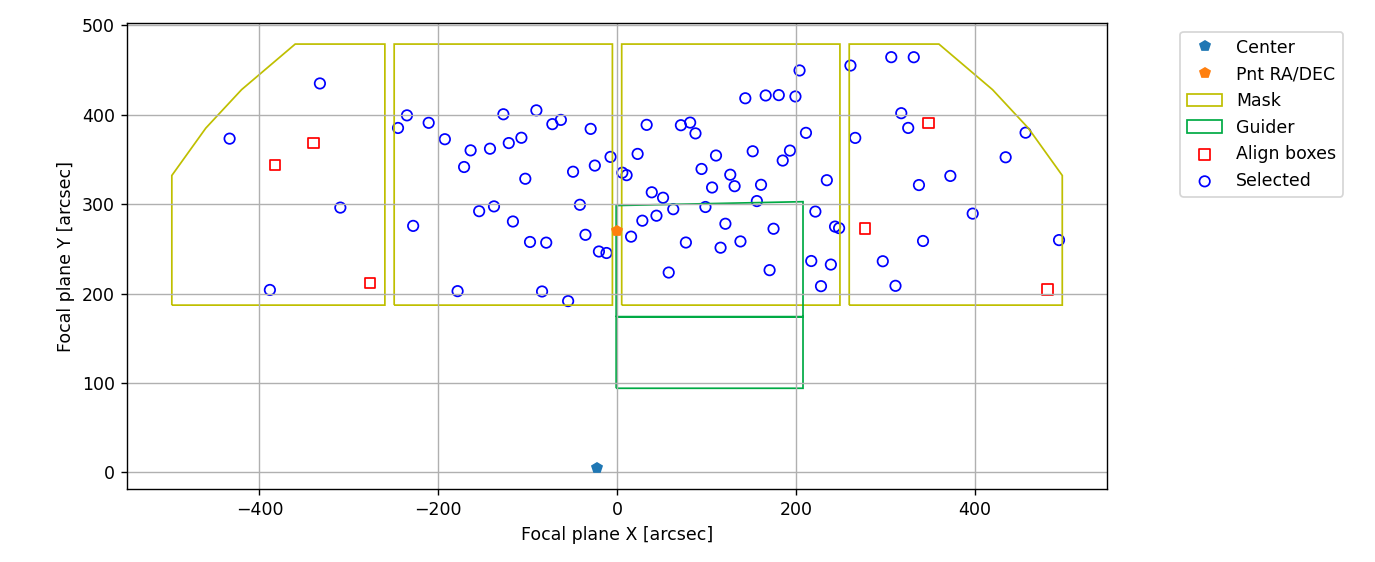

<IPython.core.display.Javascript object>

In [114]:
plt.figure(figsize=(11, 4.5))
plt.gca().set_aspect("equal")
p1 = drawUtils.drawPatch(plt.gca(), layout, fc="None", ec="y")
p1.set_label("Mask")
p2 = drawUtils.drawPatch(plt.gca(), guiderLayout, fc="None", ec="#00aa44")
p2.set_label("Guider")

plt.scatter(
    alignBoxes.xarcs,
    alignBoxes.yarcs,
    fc="None",
    ec="r",
    marker="s",
    label="Align boxes",
)

plt.scatter(
    inSelectedTargets.xarcs,
    inSelectedTargets.yarcs,
    fc="None",
    ec="b",
    marker="o",
    label="Selected",
)

plt.xlabel("Focal plane X [arcsec]")
plt.ylabel("Focal plane Y [arcsec]")

plt.plot(censX[:1], censY[:1], "p", label="Center")
plt.plot(censX[1:], censY[1:], "p", label="Pnt RA/DEC")
plt.legend(bbox_to_anchor=(1.25, 1), loc="upper right")
plt.grid()
plt.tight_layout()

## The Slits coordinates (from DSIM FITS file)
### Conversion from mm to arcsec

The slits coordinates are given in mm, so we convert them to arcsec.

In [115]:
indices = [
    "slitX1",  # Corner 1
    "slitY1",
    "slitX2",  # Corner 2
    "slitY2",
    "slitX3",  # Corner 3
    "slitY3",
    "slitX4",  # Corner 4
    "slitY4",
    "TopDist",  # Position of target inside slit
    "BotDist",
]
slitXYs = []  # Slits coordinates in mm
targetOnSlitX = []  # target coordinates in mm
targetOnSlitY = []

mm2as = utils.MM2AS
offx, offy = 0, 170
for i, row in allTargets[indices].iterrows():
    x1, y1, x2, y2, x3, y3, x4, y4, top, bot = row
    x1, x2, x3, x4 = [x * mm2as + offx for x in (x1, x2, x3, x4)]
    y1, y2, y3, y4 = [x * mm2as + offy for x in (y1, y2, y3, y4)]
    slitXYs.append((x1, y1, 0))
    slitXYs.append((x2, y2, 1))
    slitXYs.append((x3, y3, 1))
    slitXYs.append((x4, y4, 1))
    slitXYs.append((x1, y1, 2))
    xLeft, yLeft = (x1 + x4) / 2, (y1 + y4) / 2
    xRight, yRight = (x2 + x3) / 2, (y2 + y3) / 2
    tx = (xLeft * top + xRight * bot) / (top + bot)
    ty = (yLeft * top + yRight * bot) / (top + bot)
    # print("i", i, top / (top + bot))
    targetOnSlitX.append(tx)
    targetOnSlitY.append(ty)

<IPython.core.display.Javascript object>

## Calculate slits coordinates using target coordinates


In [116]:
#
# Get slit length and width from configuration
#
slitLen = config.params.minslitlength[0]
slitWidth = config.params.slitwidth[0]
slitHalf = slitLen / 2
slitHWidth = slitWidth / 2

wantSlitXYs = []  # Stores slits coordinates in arcsec

print(f"Calculate slit positions, slit width = {slitWidth}")
indices = ["xarcs", "yarcs", "TopDist", "BotDist"]

for i, (sx, sy, top, bot) in selectedTargets[indices].iterrows():
    # print ("{} {:.1f} {} {}".format(i, sx, top, bot))

    # Top-left
    x0 = sx - top
    y0 = sy - slitHWidth

    # bottom-left
    x1 = sx + bot
    y1 = sy - slitHWidth

    # bottom-right
    x2 = sx + bot
    y2 = sy + slitHWidth

    # top-right
    x3 = sx - top
    y3 = sy + slitHWidth

    wantSlitXYs.append((x0, y0, 0))
    wantSlitXYs.append((x1, y1, 1))
    wantSlitXYs.append((x2, y2, 1))
    wantSlitXYs.append((x3, y3, 1))
    wantSlitXYs.append((x0, y0, 2))

Calculate slit positions, slit width = 0.7


<IPython.core.display.Javascript object>

## Compare DSIM slits coordinates and calculated slits coordinates

### Plot the slits and the mask in arcsec

<IPython.core.display.Javascript object>


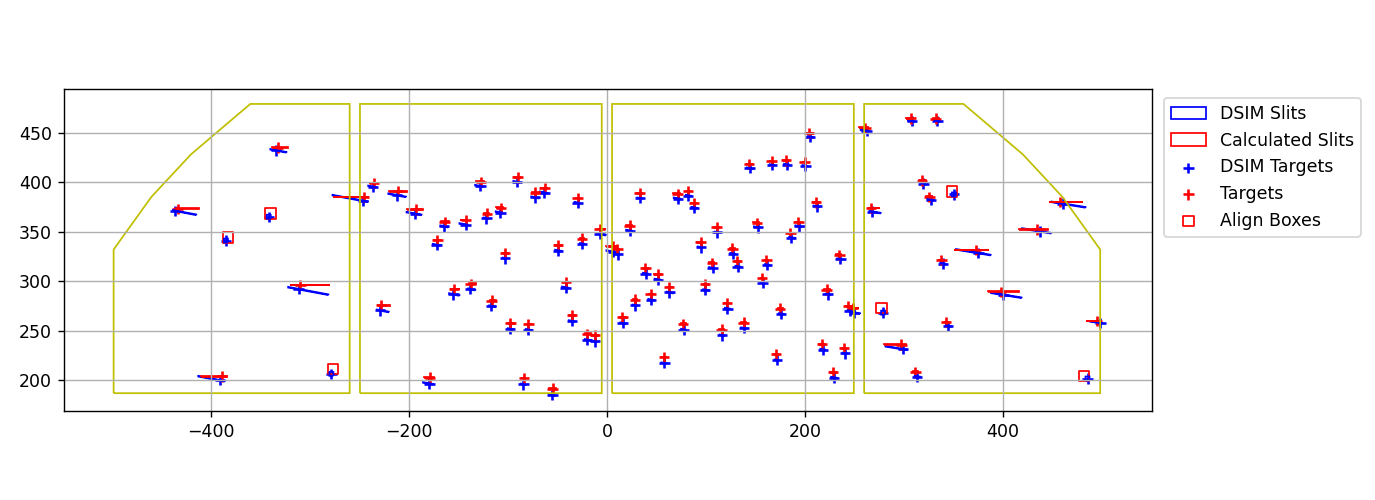

<IPython.core.display.Javascript object>

In [117]:
plt.figure(figsize=(11, 4))
plt.gca().set_aspect("equal")

# Plot the slits (from FITS file)
p1 = drawUtils.drawPatch(plt.gca(), slitXYs, fc="None", ec="b")
p1.set_label("DSIM Slits")
plt.scatter(
    targetOnSlitX, targetOnSlitY, fc="None", ec="b", marker="+", label="DSIM Targets"
)


# Plot the calculated slit position
p1 = drawUtils.drawPatch(plt.gca(), wantSlitXYs, fc="None", ec="r")
p1.set_label("Calculated Slits")
# Plot the selected targets
plt.scatter(
    selectedTargets.xarcs,
    selectedTargets.yarcs,
    fc="None",
    ec="r",
    marker="+",
    label="Targets",
)


# Plot the mask layout
drawUtils.drawPatch(plt.gca(), layout, offx=0, offy=0, fc="None", ec="y")

# Plot the alignment boxes
plt.scatter(
    alignBoxes.xarcs,
    alignBoxes.yarcs,
    fc="None",
    ec="r",
    marker="s",
    label="Align Boxes",
)
# Legend
plt.legend(bbox_to_anchor=(1.2, 1.0), loc="upper right")
plt.grid()
plt.tight_layout()

## Calculate field projection
### How to match DSIM coordinates?

In [118]:
#
# Calculate the differences in X and Y
#
dx = targetOnSlitX - allTargets.xarcs
dy = targetOnSlitY - allTargets.yarcs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


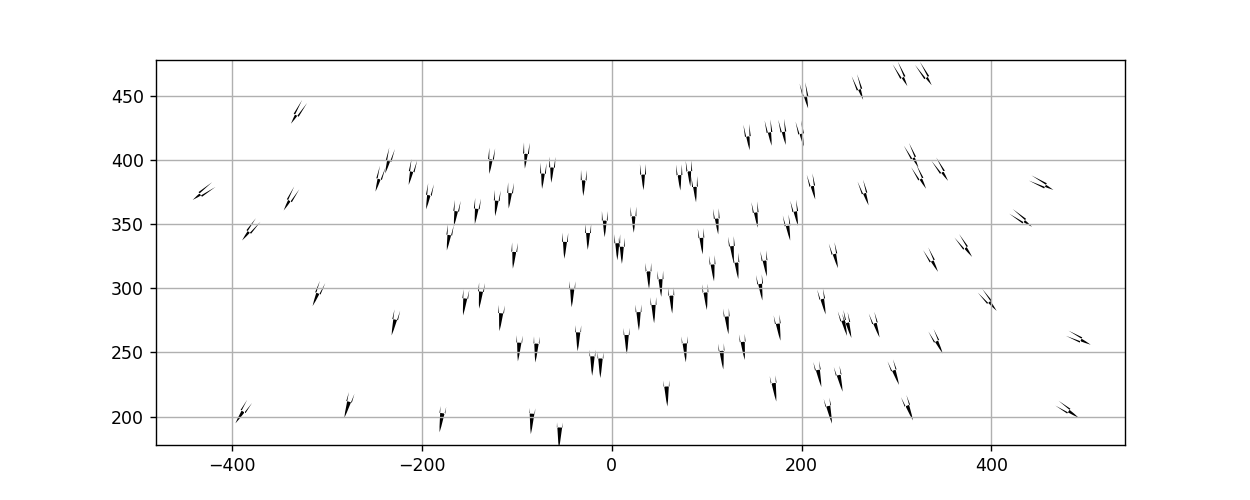

<IPython.core.display.Javascript object>

In [119]:
#
# Plot the difference between projected and original
#
plt.figure(figsize=(10, 4))
plt.gca().quiver(
    allTargets.xarcs,
    allTargets.yarcs,
    dx,
    dy,
    scale=0.4,
    scale_units="xy",
    headwidth=0.3,
    headlength=1,
)
plt.grid()

In [120]:
#
# Fit the 4th deg 2D polynomial function to map from original to calculated.
#

xModel = models.Polynomial2D(degree=4)
xfitter = fitting.LinearLSQFitter ()
xfitted = xfitter (xModel, allTargets.xarcs, allTargets.yarcs, targetOnSlitX)

yModel = models.Polynomial2D(degree=4)
yfitter = fitting.LinearLSQFitter ()
yfitted = yfitter (yModel, allTargets.xarcs, allTargets.yarcs, targetOnSlitY)


<IPython.core.display.Javascript object>

In [121]:
projectedX = xfitted(allTargets.xarcs, allTargets.yarcs)
projectedY = yfitted(allTargets.xarcs, allTargets.yarcs)

alignProjX = xfitted(alignBoxes.xarcs, alignBoxes.yarcs)
alignProjY = yfitted(alignBoxes.xarcs, alignBoxes.yarcs)

#
# Calculate projected slits
#

projSlitXYs = []  #

print(f"Calculate projected slit positions, slit width = {slitWidth}")
indices = ["xarcs", "yarcs", "TopDist", "BotDist"]

rotAngle = np.radians(10)
sinA = np.sin(rotAngle)
cosA = np.cos(rotAngle)


def proj(x, y):
    return xfitted(x, y), yfitted(x, y)


for i, (sx, sy, top0, bot0) in selectedTargets[indices].iterrows():
    # print ("{} {:.1f} {} {}".format(i, sx, top, bot))

    leftx = cosA * top0
    lefty = sinA * top0
    rightx = cosA * bot0
    righty = sinA * bot0

    # bottom-left
    x0 = sx - leftx
    y0 = sy + lefty
    x0, y0 = proj(x0, y0)
    y0 -= slitHWidth

    # bottom-right
    x1 = sx + rightx
    y1 = sy - righty
    x1, y1 = proj(x1, y1)
    y1 -= slitHWidth

    # top-right
    x2 = sx + rightx
    y2 = sy - righty
    x2, y2 = proj(x2, y2)
    y2 += slitHWidth

    # top-left
    x3 = sx - leftx
    y3 = sy + lefty
    x3, y3 = proj(x3, y3)
    y3 += slitHWidth

    projSlitXYs.append((x0, y0, 0))
    projSlitXYs.append((x1, y1, 1))
    projSlitXYs.append((x2, y2, 1))
    projSlitXYs.append((x3, y3, 1))
    projSlitXYs.append((x0, y0, 2))

Calculate projected slit positions, slit width = 0.7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


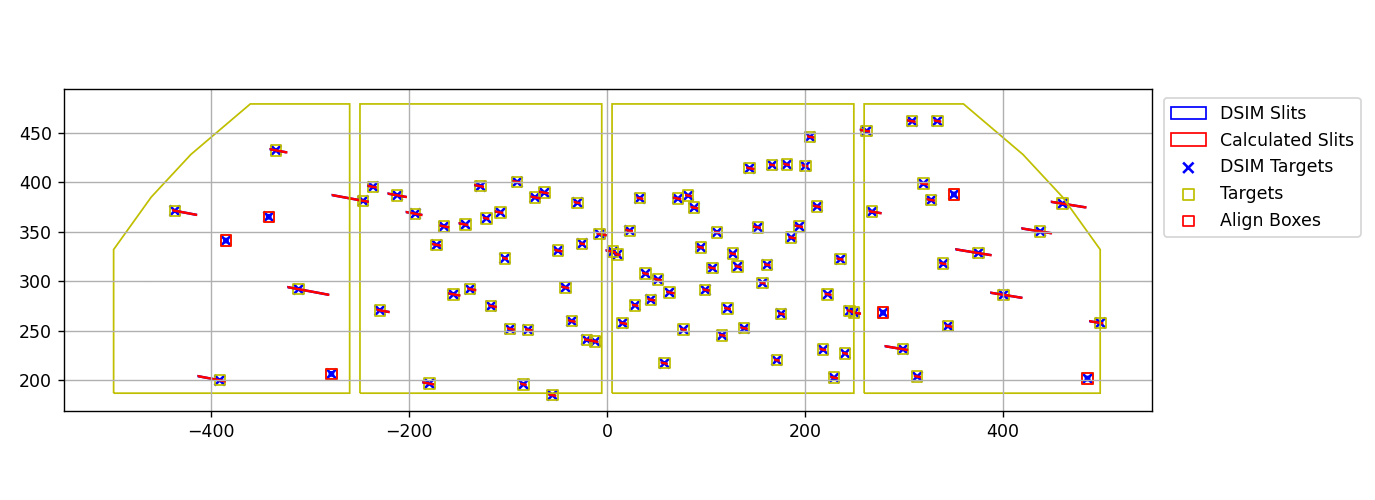

<IPython.core.display.Javascript object>

In [122]:
#
# Plot the coordinates using the fitted model
#
plt.figure(figsize=(11, 4))
plt.gca().set_aspect("equal")

# Plot the slits (from FITS file)
p1 = drawUtils.drawPatch(plt.gca(), slitXYs, fc="None", ec="b")
p1.set_label("DSIM Slits")
plt.scatter(
    targetOnSlitX, targetOnSlitY, fc="None", ec="b", marker="x", label="DSIM Targets"
)

# Plot the calculated slit position
p1 = drawUtils.drawPatch(plt.gca(), projSlitXYs, fc="None", ec="r")
p1.set_label("Calculated Slits")
# Plot the selected targets
plt.scatter(
    projectedX,
    projectedY,
    fc="None",
    ec="y",
    marker="s",
    label="Targets",
)

# Plot the mask layout
drawUtils.drawPatch(plt.gca(), layout, offx=0, offy=0, fc="None", ec="y")

# Plot the alignment boxes
plt.scatter(
    alignProjX,
    alignProjY,
    fc="None",
    ec="r",
    marker="s",
    label="Align Boxes",
)
# Legend
plt.legend(bbox_to_anchor=(1.2, 1.0), loc="upper right")
plt.grid()
plt.tight_layout()

In [123]:
with np.printoptions(precision=4, suppress=True):
    print(xfitted.parameters)
    print(yfitted.parameters)

[ 0.0426  1.0053 -0.      0.      0.     -0.0004  0.     -0.      0.
 -0.      0.     -0.      0.     -0.      0.    ]
[-8.4533  0.0002  0.     -0.      0.      1.0097  0.     -0.      0.
 -0.      0.     -0.     -0.     -0.      0.    ]


<IPython.core.display.Javascript object>